In [1]:
using Revise
using LinearAlgebra
using MatrixMarket
using EAMC
using SparseArrays
using Plots
using Interact

┌ Info: Precompiling EAMC [d0d32b4c-83b1-4490-9109-c03fdd3b1e42]
└ @ Base loading.jl:1273


HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-3221936542394154616\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-16528540677149594497\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-3221936542394154616\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [2]:
## load data
using MatrixMarket
data = cd("data/natalia191219") do 
    map(MatrixMarket.mmread, readdir())
end;

In [3]:
## adjust diagonal to be a proper q matrix
using LinearAlgebra
qs = data
qs = map(qs) do q
    q = q
    q .- Diagonal(sum(q, dims=2)|>vec) # mass conservation
end;

In [63]:
## galerkin discretization of the eamc
using EAMC
dt = ones(length(qs))
dt[end] = 1000
tmax = length(qs)
g = @time EAMC.galerkin(qs[1:tmax], dt[1:tmax]);

  3.072173 seconds (10.10 k allocations: 4.566 GiB, 13.06% gc time)


In [85]:
## create commitor systems
using SparseArrays

TT = g - I
nm = size(TT, 1)
n = 900
bnd = nm - n

# fix non-transitions by assigning them to the target set
s = sum(TT, dims=2)
for i in 1 : nm
    TT[i, nm - n + (i-1)%n + 1] = -s[i]
end

# set boundary condition
for i in bnd+1 : nm
    TT[i,:] .= 0
    TT[i,i] = 1
end

In [87]:
## create commitor terminal condition
term = spzeros(nm,n)
term[nm-n+1:end, :] = sparse(I, n,n);

In [88]:
## solve commitors

@time cs = TT\collect(term);

 16.668767 seconds (3.67 k allocations: 1.458 GiB, 0.20% gc time)


In [89]:
cc = reshape(cs, 30, 30, 24, 30, 30)

30×30×24×30×30 Array{Float64,5}:
[:, :, 1, 1, 1] =
 0.68343    0.68343    0.683416   0.683388   …  0.708107  0.701298  0.688179
 0.683553   0.683552   0.683527   0.683476      0.683967  0.683906  0.675849
 0.683705   0.6837     0.683654   0.683571      0.615831  0.635402  0.636805
 0.683847   0.683832   0.683759   0.683647      0.55461   0.580617  0.590709
 0.683992   0.683954   0.683846   0.683694      0.529488  0.535867  0.545709
 0.684124   0.68405    0.683876   0.683659   …  0.521902  0.511073  0.510077
 0.684222   0.684071   0.683795   0.683504      0.529249  0.506965  0.501285
 0.684251   0.683972   0.683625   0.683316      0.54757   0.527133  0.516937
 0.684192   0.683788   0.683438   0.683155      0.56688   0.549736  0.538377
 0.684087   0.683603   0.68326    0.683047      0.580577  0.566201  0.554033
 0.683969   0.683491   0.683198   0.682984   …  0.588464  0.576838  0.564128
 0.68402    0.683541   0.683259   0.68299       0.593085  0.584367  0.572756
 0.684223   0.683731   0.

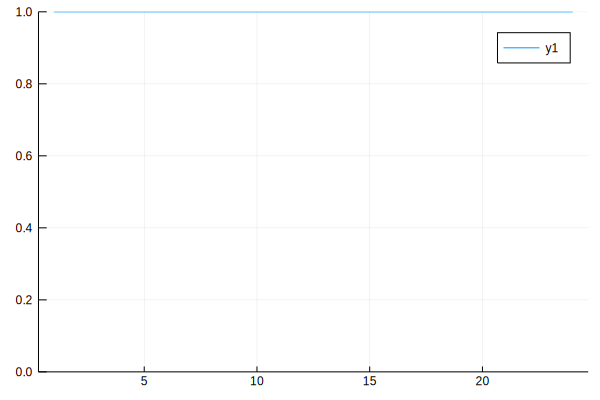

In [104]:
## starting with uniformly distributed mass at time t, how much of that mass is retained until t=24

plot([sum(cc[:,:,t,:,:])/900 for t=1:24], ylims=(0,1))